Glad to finish my first neural network! Thanks to all kindly people who shared their kernal and write guidance for beginners. This kernal is written in Pytorch, and ResNet50 of fastai models is used to build siamese network.
Special thanks to [this article](https://www.kaggle.com/leonbora/kinship-recognition-transfer-learning-vggface). It is the first time for me to see data organized like this, and his kernal gives me an example to deal with them. I copied the data processing code from his kernal , as can be seen in the 4th code block.
Also thanks to [harveyslash](https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch/tree/master), his code is taught [here](https://www.pytorchtutorial.com/pytorch-one-shot-learning/) in Chinese. By reading his tutorial I have a thorough understanding about how to write pytorch code, and the basic use of dataloader and network. After finish this work the first time, I accidently found that most of his code is similar to the [official tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html?highlight=cifar). Though I ran this tutorial a month ago, I didn't learn a lot from it.
Finally, thanks to kaggle for offering this platform and 16G GPU for us. I really appreciate it. 
If you are also beginner as I do, just get your hands dirty. Once finish a competition by yourself, you will learn a lot from it.
Best wishes to you!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Data manipulation
import numpy as np
import pandas as pd

# Data visualisation
import matplotlib.pyplot as plt

# Fastai
from fastai.vision import *
from fastai.vision.models import *

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils
import torchvision.datasets as dset 

from torch import optim
from torch.utils.data import DataLoader,Dataset
from torchvision.models import *
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
import torchvision.models as models

from pathlib import Path
import sys

from glob import glob
from PIL import Image

In [ ]:
np.random.seed(42)

BATCH_SIZE= 25
NUMBER_EPOCHS=60
IMG_SIZE=100

In [ ]:
def imshow(img,text=None,should_save=False):#for showing the data you loaded to dataloader
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):# for showing loss value changed with iter
    plt.plot(iteration,loss)
    plt.show()


In [ ]:
#PREPARAZIONE TRAINSET E VALSET
import scipy.io 
matFD = scipy.io.loadmat("/content/drive/MyDrive/kinship project/Datasets/fd_pairs.mat")
matFS = scipy.io.loadmat("/content/drive/MyDrive/kinship project/Datasets/fs_pairs.mat")
matMD = scipy.io.loadmat("/content/drive/MyDrive/kinship project/Datasets/md_pairs.mat")
matMS = scipy.io.loadmat("/content/drive/MyDrive/kinship project/Datasets/ms_pairs.mat")

# Restituisce una matrice avente coppie con labels dei quantili specificati per ogni .mat
def filterRelation(QuantileIniziale, QuantileFinale):
        tab = []
        for r in matFD["pairs"]:
                if r[0][0][0] in range(QuantileIniziale, QuantileFinale + 1) and r[1][0][0] == 1:
                        tab.append([ r[2][0], r[3][0], 0 ]) # fd = 0

        for r in matFS["pairs"]:
                if r[0][0][0] in range(QuantileIniziale, QuantileFinale + 1) and r[1][0][0] == 1:
                        tab.append([ r[2][0], r[3][0], 1 ]) # fs = 1

        for r in matMD["pairs"]:
                if r[0][0][0] in range(QuantileIniziale, QuantileFinale + 1) and r[1][0][0] == 1:
                        tab.append([ r[2][0], r[3][0], 2 ]) # md = 2

        for r in matMS["pairs"]:
                if r[0][0][0] in range(QuantileIniziale, QuantileFinale + 1) and r[1][0][0] == 1:
                        tab.append([ r[2][0], r[3][0], 3 ]) # ms = 3

        return tab

In [ ]:
#Restituisce il quantile indicato di ogni .mat
def getQuantile(i):

        quantile = []
        for r in matFD["pairs"]:
                if r[0][0][0] ==i and r[1][0][0] == 1:
                        quantile.append([ r[2][0], r[3][0], 0 ]) # fd = 0

        for r in matFS["pairs"]:
                if r[0][0][0] == i and r[1][0][0] == 1:
                        quantile.append([ r[2][0], r[3][0], 1 ]) # fs = 1

        for r in matMD["pairs"]:
                if r[0][0][0] == i and r[1][0][0] == 1:
                        quantile.append([ r[2][0], r[3][0], 2 ]) # md = 2

        for r in matMS["pairs"]:
                if r[0][0][0] == i and r[1][0][0] == 1:
                        quantile.append([ r[2][0], r[3][0], 3 ]) # ms = 3

        return quantile


In [ ]:
train = getQuantile(1) + getQuantile(2) +getQuantile(3)
val = filterRelation(5, 5)


print("Total train pairs:", len(train))    
print("Total val pairs:", len(val))    

Total train pairs: 600
Total val pairs: 200


In [ ]:
class trainingDataset(Dataset):#Get two images and whether they are related.
    
    def __init__(self,imageFolderDataset, relationships, transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.relationships = relationships 
        self.transform = transform
        
    def __getitem__(self,index):
        row = self.relationships[index]
        
        if row[2] == 0: #è una relazione fd
            img0_path = "/content/drive/MyDrive/kinship project/Datasets/KinFaceW-II/images/father-dau/"+row[0]
            img1_path = "/content/drive/MyDrive/kinship project/Datasets/KinFaceW-II/images/father-dau/"+row[1]

        elif row[2] == 1: #è una relazione fs
            img0_path = "/content/drive/MyDrive/kinship project/Datasets/KinFaceW-II/images/father-son/"+row[0]
            img1_path = "/content/drive/MyDrive/kinship project/Datasets/KinFaceW-II/images/father-son/"+row[1]

        elif row[2] == 2: #è una relazione md 
            img0_path = "/content/drive/MyDrive/kinship project/Datasets/KinFaceW-II/images/mother-dau/"+row[0]
            img1_path = "/content/drive/MyDrive/kinship project/Datasets/KinFaceW-II/images/mother-dau/"+row[1]

        elif row[2] == 3: #è una relazione ms mother-son
            img0_path = "/content/drive/MyDrive/kinship project/Datasets/KinFaceW-II/images/mother-son/"+row[0]
            img1_path = "/content/drive/MyDrive/kinship project/Datasets/KinFaceW-II/images/mother-son/"+row[1]


        #print("image path1:", img0_path, " image path2:", img1_path)

        img0 = Image.open(img0_path)
        img1 = Image.open(img1_path)

        #print("__getitem__:", img0_path, img0_path, "tipo:",  row[2])
        
        if self.transform is not None:#I think the transform is essential if you want to use GPU, because you have to trans data to tensor first.
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , row[2] #the returned data from dataloader is img=[batch_size,channels,width,length], should_get_same_class=[batch_size,label]
    
    def __len__(self):
        return len(self.relationships)#essential for choose the num of data in one epoch

In [ ]:
folder_dataset = dset.ImageFolder(root='/content/drive/MyDrive/kinship project/Datasets/KinFaceW-II/images')

trainset = trainingDataset(imageFolderDataset=folder_dataset,
                                        relationships=train,
                                        transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))
trainloader = DataLoader(trainset,
                        shuffle=True,#whether randomly shuffle data in each epoch, but cannot let data in one batch in order.
                        num_workers=2,
                        batch_size=BATCH_SIZE)
valset = trainingDataset(imageFolderDataset=folder_dataset,
                                        relationships=val,
                                        transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))
valloader = DataLoader(valset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=BATCH_SIZE)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


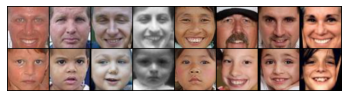

[1 0 1 3 2 0 1 3]


In [ ]:
#only for visualize data in dataloader, it won't matters if you delete this block.
vis_dataloader = DataLoader(trainset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)

dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        model = models.densenet161(pretrained=True)  #Carico Densenet161 già allenata

        #Freezing tutti i layers
        for param in model.parameters():
          param.require_grad = False

        #Estrazione blocco convoluzionale
        self.cnn1 = torch.nn.Sequential(*(list(model.children())[:-1]))

        #Aggiungo nuovi layers pienamente connessi
        model.classifier = nn.Sequential(
            nn.Linear(39744, 460),
            nn.ReLU(),
            nn.Linear(460,4),            
        )

        self.fc = model.classifier 


    def forward(self, input1, input2):
        output1 = self.cnn1(input1)
        output1 = output1.view(output1.size()[0], -1)#make it suitable for fc layer.
        output2 = self.cnn1(input2)
        output2 = output2.view(output2.size()[0], -1)
        
        output = torch.cat((output1, output2),1)
        #print(output.shape) #è l'output che deve aver il primo fc
        output = self.fc(output)
        return output

batch size: 25
Img size: 100
SiameseNetwork(
  (cnn1): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d

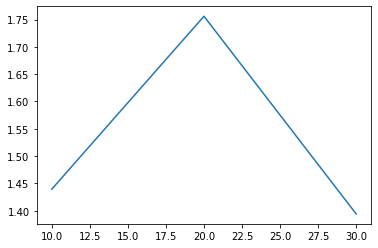

Epoch： 1  start.
Accuracy of the network on the 200 val pairs in: 39 %


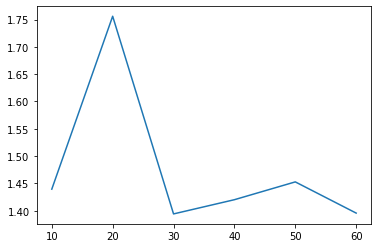

Epoch： 2  start.
Accuracy of the network on the 200 val pairs in: 42 %


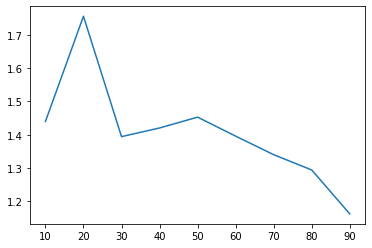

Epoch： 3  start.
Accuracy of the network on the 200 val pairs in: 51 %


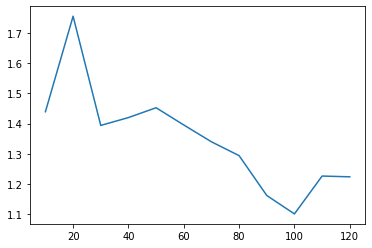

Epoch： 4  start.
Accuracy of the network on the 200 val pairs in: 55 %


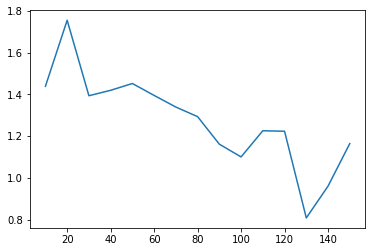

Epoch： 5  start.
Accuracy of the network on the 200 val pairs in: 56 %


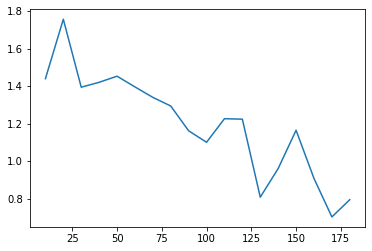

Epoch： 6  start.
Accuracy of the network on the 200 val pairs in: 49 %


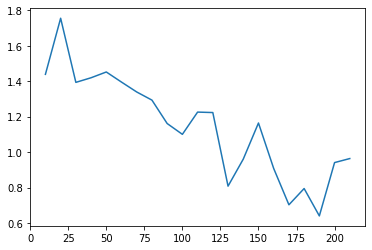

Epoch： 7  start.
Accuracy of the network on the 200 val pairs in: 55 %


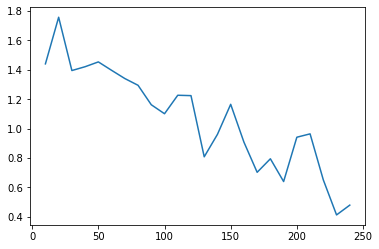

Epoch： 8  start.
Accuracy of the network on the 200 val pairs in: 60 %


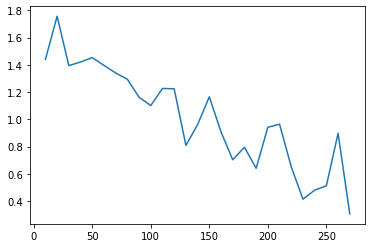

Epoch： 9  start.
Accuracy of the network on the 200 val pairs in: 54 %


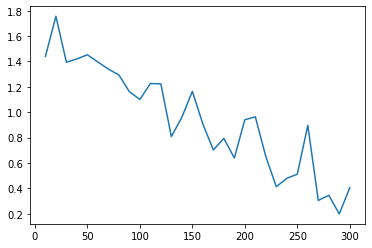

Epoch： 10  start.
Accuracy of the network on the 200 val pairs in: 62 %


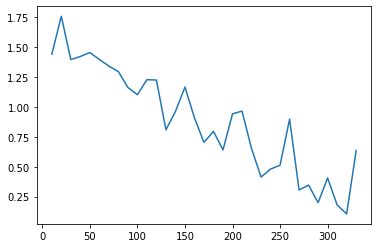

Epoch： 11  start.
Accuracy of the network on the 200 val pairs in: 50 %


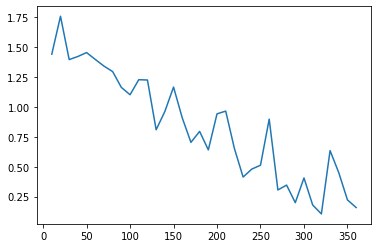

Epoch： 12  start.
Accuracy of the network on the 200 val pairs in: 58 %


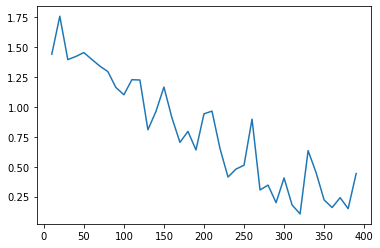

Epoch： 13  start.
Accuracy of the network on the 200 val pairs in: 54 %


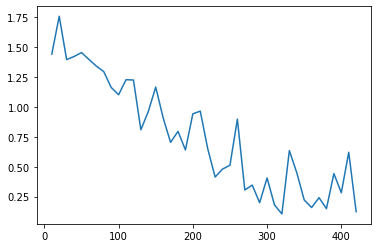

Epoch： 14  start.
Accuracy of the network on the 200 val pairs in: 53 %


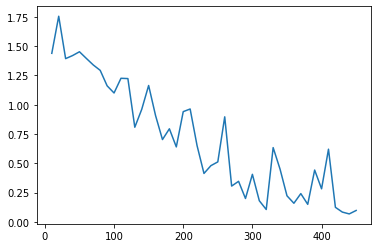

Epoch： 15  start.
Accuracy of the network on the 200 val pairs in: 62 %


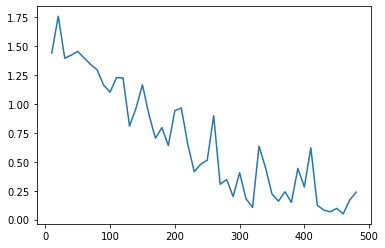

Epoch： 16  start.
Accuracy of the network on the 200 val pairs in: 52 %


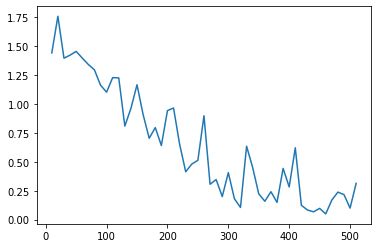

Epoch： 17  start.
Accuracy of the network on the 200 val pairs in: 54 %


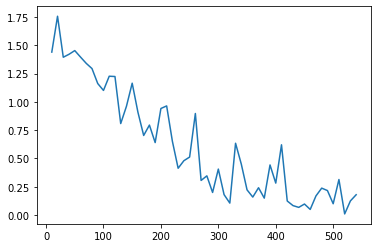

Epoch： 18  start.
Accuracy of the network on the 200 val pairs in: 55 %


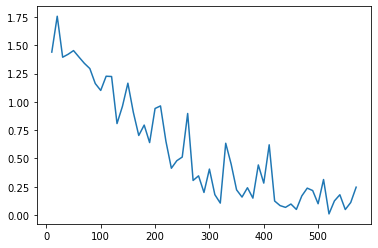

Epoch： 19  start.
Accuracy of the network on the 200 val pairs in: 60 %


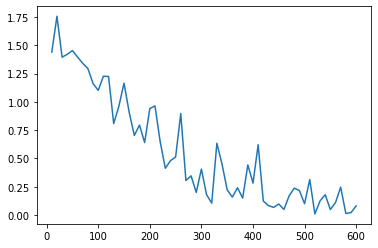

Epoch： 20  start.
Accuracy of the network on the 200 val pairs in: 61 %


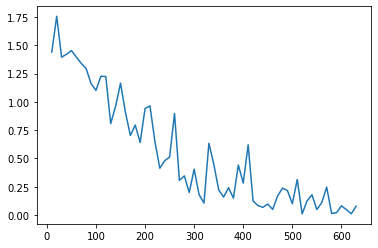

Epoch： 21  start.
Accuracy of the network on the 200 val pairs in: 62 %


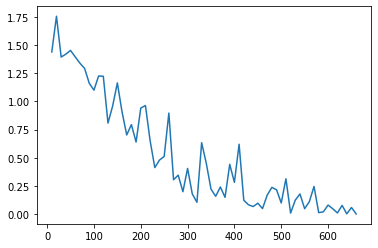

Epoch： 22  start.
Accuracy of the network on the 200 val pairs in: 57 %


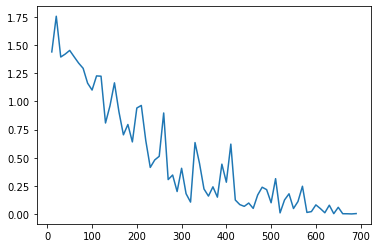

Epoch： 23  start.
Accuracy of the network on the 200 val pairs in: 59 %


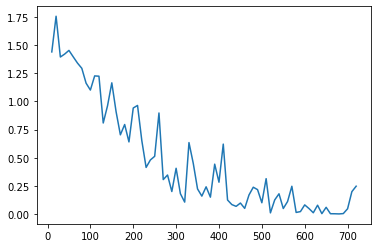

Epoch： 24  start.
Accuracy of the network on the 200 val pairs in: 58 %


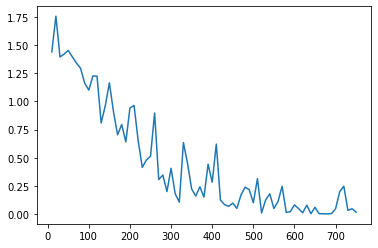

Epoch： 25  start.
Accuracy of the network on the 200 val pairs in: 59 %


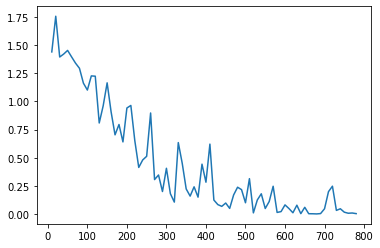

Epoch： 26  start.
Accuracy of the network on the 200 val pairs in: 52 %


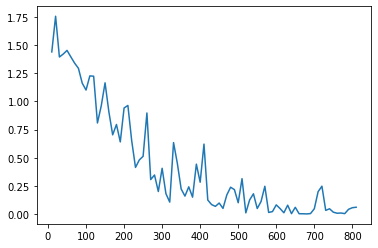

Epoch： 27  start.
Accuracy of the network on the 200 val pairs in: 52 %


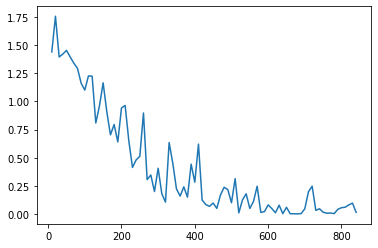

Epoch： 28  start.
Accuracy of the network on the 200 val pairs in: 59 %


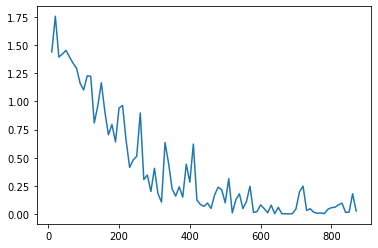

Epoch： 29  start.
Accuracy of the network on the 200 val pairs in: 62 %


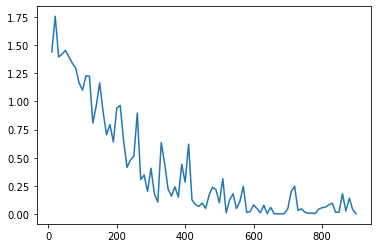

Epoch： 30  start.
Accuracy of the network on the 200 val pairs in: 64 %


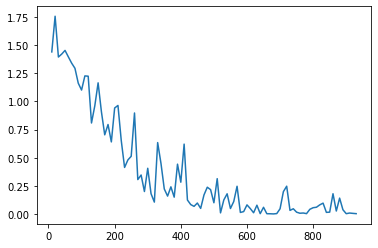

Epoch： 31  start.
Accuracy of the network on the 200 val pairs in: 58 %


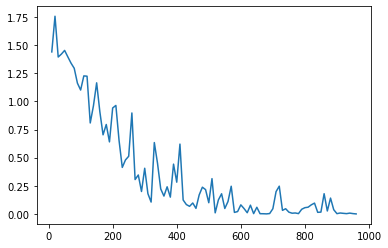

Epoch： 32  start.
Accuracy of the network on the 200 val pairs in: 60 %


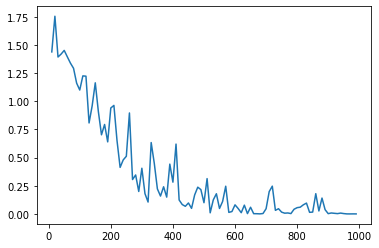

Epoch： 33  start.
Accuracy of the network on the 200 val pairs in: 58 %


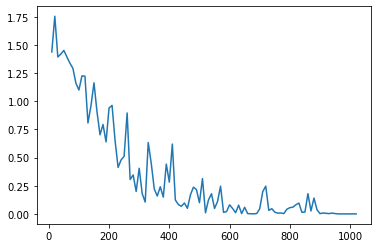

Epoch： 34  start.
Accuracy of the network on the 200 val pairs in: 59 %


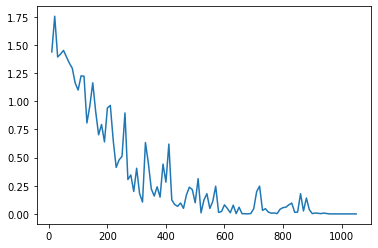

Epoch： 35  start.
Accuracy of the network on the 200 val pairs in: 60 %


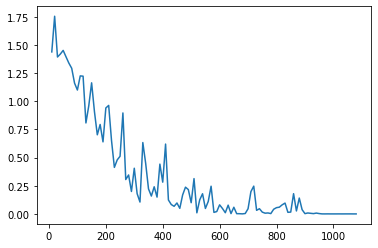

Epoch： 36  start.
Accuracy of the network on the 200 val pairs in: 60 %


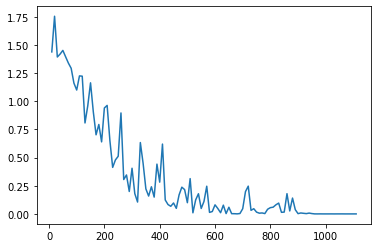

Epoch： 37  start.
Accuracy of the network on the 200 val pairs in: 60 %


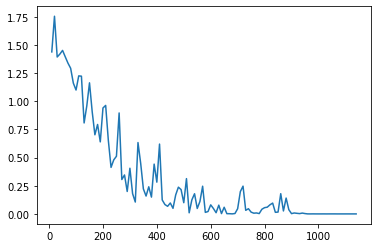

Epoch： 38  start.
Accuracy of the network on the 200 val pairs in: 60 %


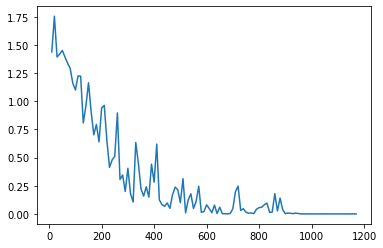

Epoch： 39  start.
Accuracy of the network on the 200 val pairs in: 60 %


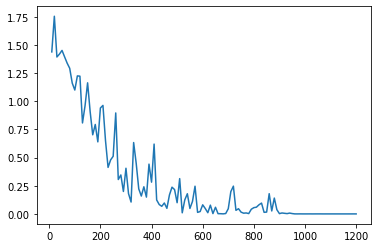

Epoch： 40  start.
Accuracy of the network on the 200 val pairs in: 60 %


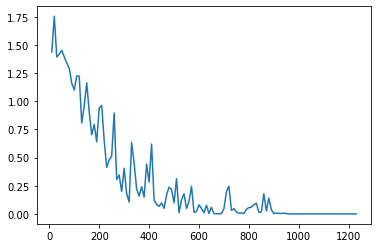

Epoch： 41  start.
Accuracy of the network on the 200 val pairs in: 60 %


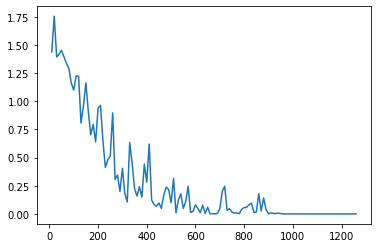

Epoch： 42  start.
Accuracy of the network on the 200 val pairs in: 60 %


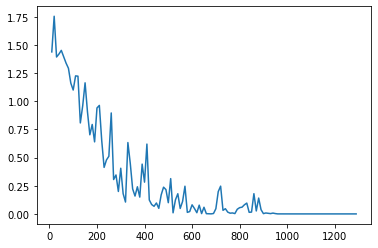

Epoch： 43  start.
Accuracy of the network on the 200 val pairs in: 60 %


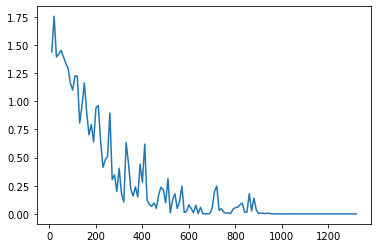

Epoch： 44  start.
Accuracy of the network on the 200 val pairs in: 60 %


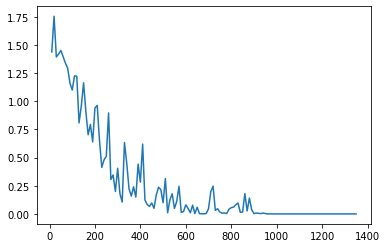

Epoch： 45  start.
Accuracy of the network on the 200 val pairs in: 60 %


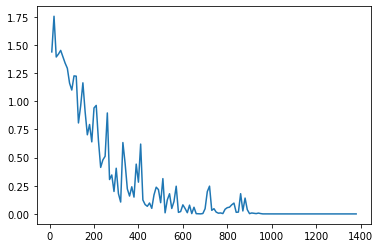

Epoch： 46  start.
Accuracy of the network on the 200 val pairs in: 60 %


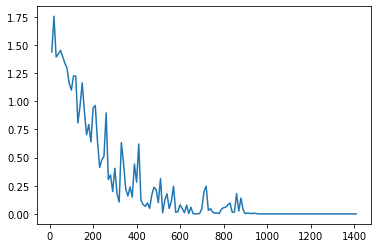

Epoch： 47  start.
Accuracy of the network on the 200 val pairs in: 60 %


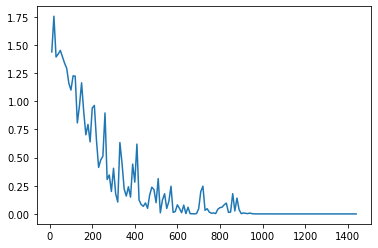

Epoch： 48  start.
Accuracy of the network on the 200 val pairs in: 60 %


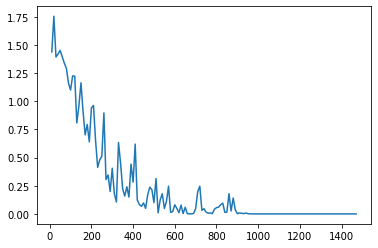

Epoch： 49  start.
Accuracy of the network on the 200 val pairs in: 60 %


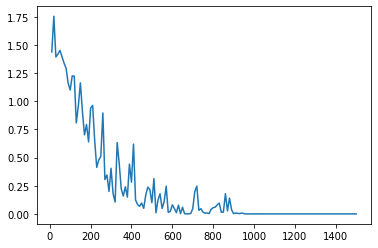

Epoch： 50  start.
Accuracy of the network on the 200 val pairs in: 60 %


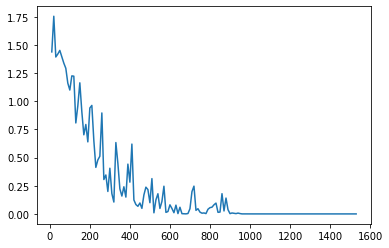

Epoch： 51  start.
Accuracy of the network on the 200 val pairs in: 60 %


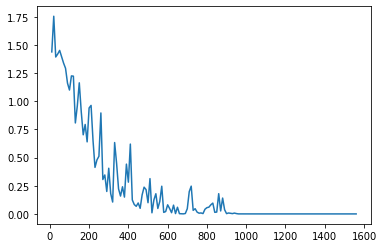

Epoch： 52  start.
Accuracy of the network on the 200 val pairs in: 60 %


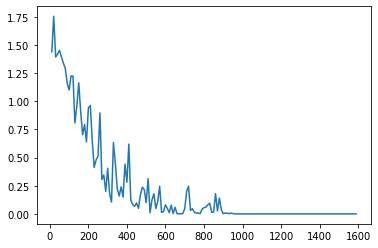

Epoch： 53  start.
Accuracy of the network on the 200 val pairs in: 60 %


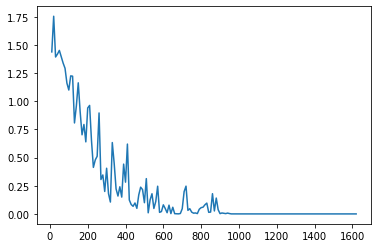

Epoch： 54  start.
Accuracy of the network on the 200 val pairs in: 60 %


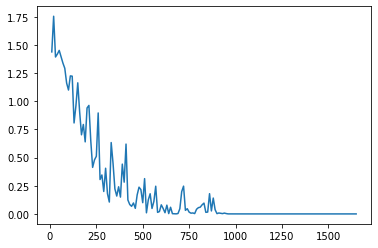

Epoch： 55  start.
Accuracy of the network on the 200 val pairs in: 60 %


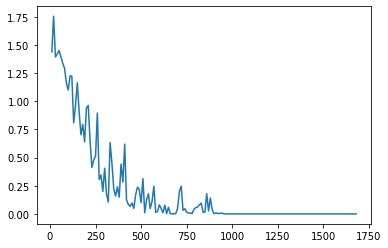

Epoch： 56  start.
Accuracy of the network on the 200 val pairs in: 60 %


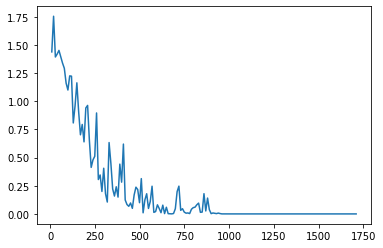

Epoch： 57  start.
Accuracy of the network on the 200 val pairs in: 60 %


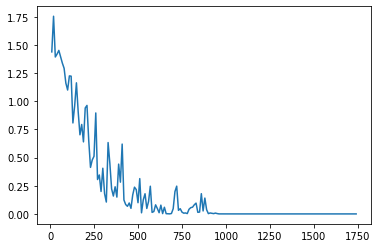

Epoch： 58  start.
Accuracy of the network on the 200 val pairs in: 60 %


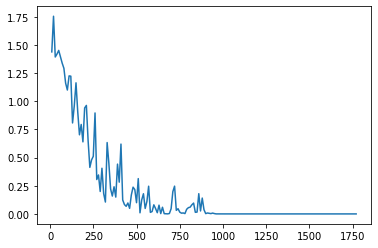

Epoch： 59  start.
Accuracy of the network on the 200 val pairs in: 60 %


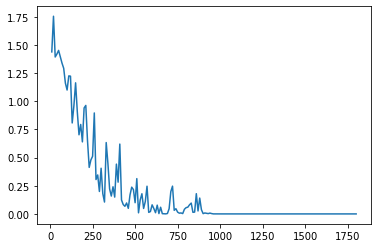

In [ ]:
net = SiameseNetwork().cuda()


criterion = nn.CrossEntropyLoss() # use a Classification Cross-Entropy loss
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)



print("batch size:", BATCH_SIZE)
print("Img size:", IMG_SIZE)
print(net.eval())
#torch.cuda.empty_cache()
counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(0,NUMBER_EPOCHS):
    print("Epoch：", epoch, " start.")
    for i, data in enumerate(trainloader,0):
        img0, img1 , labels = data #img=tensor[batch_size,channels,width,length], label=tensor[batch_size,label]
        img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()#move to GPU
        #print("epoch：", epoch, "No." , i, "th inputs", img0.data.size(), "labels", labels.data.size())
        optimizer.zero_grad()#clear the calculated grad in previous batch
        outputs = net(img0,img1)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        if i %10 == 0 :#show changes of loss value after each 10 batches
            #print("Epoch number {}\n Current loss {}\n".format(epoch,loss.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss.item())
    
    #test the network after finish each epoch, to have a brief training result.
    correct_val = 0
    total_val = 0
    with torch.no_grad():#essential for testing!!!!
        for data in valloader:
            img0, img1 , labels = data
            img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()
            outputs = net(img0,img1)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    print('Accuracy of the network on the', total_val, 'val pairs in: %d %%' % (100 * correct_val / total_val))
    show_plot(counter,loss_history)
    

In [ ]:
class testDataset(Dataset): #different from train dataset, because the data organized in submission.csv is different from train.csv
    
    def __init__(self,relationships, transform=None):
        self.relationships = relationships 
        self.transform = transform
        
        
    def __getitem__(self,index):
        row = self.relationships[index]
        
        if row[2] == 0: #è una relazione fd
            img0_path = "/content/drive/MyDrive/kinship project/Datasets/KinFaceW-II/images/father-dau/"+row[0]
            img1_path ="/content/drive/MyDrive/kinship project/Datasets/KinFaceW-II/images/father-dau/"+row[1]

        elif row[2] == 1: #è una relazione fs
            img0_path = "/content/drive/MyDrive/kinship project/Datasets/KinFaceW-II/images/father-son/"+row[0]
            img1_path = "/content/drive/MyDrive/kinship project/Datasets/KinFaceW-II/images/father-son/"+row[1]

        elif row[2] == 2: #è una relazione md 
            img0_path = "/content/drive/MyDrive/kinship project/Datasets/KinFaceW-II/images/mother-dau/"+row[0]
            img1_path = "/content/drive/MyDrive/kinship project/Datasets/KinFaceW-II/images/mother-dau/"+row[1]

        elif row[2] == 3: #è una relazione ms mother-son
            img0_path = "/content/drive/MyDrive/kinship project/Datasets/KinFaceW-II/images/mother-son/"+row[0]
            img1_path = "/content/drive/MyDrive/kinship project/Datasets/KinFaceW-II/images/mother-son/"+row[1]

        

        img0 = Image.open(img0_path)
        img1 = Image.open(img1_path)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , row[2] 

    def __len__(self):
        return len(self.relationships)
    


In [ ]:
test_set = getQuantile(4)
testset = testDataset( relationships = test_set,  transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))

testloader = DataLoader(testset,
                        shuffle= False,
                        num_workers=0,
                        batch_size=1)#Both extra workers and batch size lead to data out of order, the submission.csv will be out of order
#if you have better method, please tell me! thanks a lot!

In [ ]:
test_df = pd.DataFrame(test_set)
test_df.columns = ['Immagine1', 'Immagine2', "Tipo Parentela"]

In [ ]:
######################
#carico pesi da un altro eventuale modello
# PATH = "/content/drive/MyDrive/kinship_prediction/input/densenetSplit1345.pth"
# model  = torch.load(PATH)

# net = model.cuda()
######################

predictions=[]
etichette = []
correct_val = 0
total = 0

with torch.no_grad():
    for data in testloader:
        img0, img1, labels = data
        img0, img1, labels = img0.cuda(), img1.cuda(), labels.cuda()
        outputs = net(img0,img1)
        _, predicted = torch.max(outputs, 1)
        predictions = np.concatenate((predictions,predicted.cpu().numpy()),0)#taking care of here, the output data format is important for transfer

        correct_val += (predicted == labels).sum().item()
        total += labels.size(0)


print(f"Accuratezza del modello: {float(correct_val)/float(total)*100:.2f}")

test_df['Predizione'] = predictions
test_df.to_csv("/content/drive/MyDrive/kinship project/MyPrediction.csv", index=False)#submission.csv should be placed directly in current fold.
test_df.head(300)#show the result to be committed


Accuratezza del modello: 68.00


,Immagine1,Immagine2,Tipo Parentela,Predizione
0,fd_003_1.jpg,fd_003_2.jpg,0,2.0
1,fd_147_1.jpg,fd_147_2.jpg,0,1.0
2,fd_161_1.jpg,fd_161_2.jpg,0,1.0
3,fd_160_1.jpg,fd_160_2.jpg,0,0.0
4,fd_011_1.jpg,fd_011_2.jpg,0,0.0
...,...,...,...,...
195,ms_108_1.jpg,ms_108_2.jpg,3,3.0
196,ms_006_1.jpg,ms_006_2.jpg,3,2.0
197,ms_125_1.jpg,ms_125_2.jpg,3,3.0
198,ms_113_1.jpg,ms_113_2.jpg,3,3.0


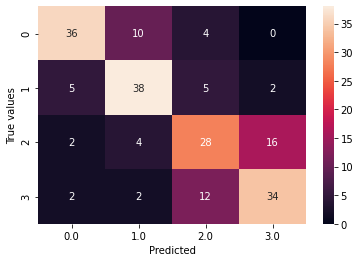

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

#Crea matrice di confusione
confusion_matrix = pd.crosstab(test_df['Tipo Parentela'], test_df['Predizione'], rownames=['True values'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()

In [ ]:
#Salva modello rete con pesi
#saved_path = "/content/drive/MyDrive/kinship_prediction/input/densenetSplit1245.pth"
#torch.save(net, saved_path)
